0. Preparing dataset

In [97]:
# https://drive.google.com/file/d/1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu/view?usp=sharing
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 41.6MB/s]


## **1. Import libraries**

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## **2. Read dataset**

In [99]:
dataset_path = "/content/Auto_MPG_data.csv"
df = pd.read_csv(dataset_path)
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [100]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.173469,0.201531,0.625000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.379136,0.401656,0.484742
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


## **3. Preprocessing data**

In [102]:
X = df.drop(columns='MPG').values
y = df['MPG'].values

In [103]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [104]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 273
Number of val samples: 79
Number of test samples: 40


In [105]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [106]:
X_train

tensor([[-0.8414, -1.0379, -1.0381,  ..., -0.4443,  1.9045, -1.2748],
        [ 0.3676,  0.3682,  0.2230,  ..., -0.4443, -0.5251,  0.7845],
        [-0.8414, -0.9165, -0.8980,  ..., -0.4443, -0.5251,  0.7845],
        ...,
        [ 1.5766,  1.3091,  1.3439,  ..., -0.4443, -0.5251,  0.7845],
        [ 0.3676,  0.4391, -0.3375,  ..., -0.4443, -0.5251,  0.7845],
        [ 0.3676,  0.6211, -0.0573,  ..., -0.4443, -0.5251,  0.7845]])

## **4. Create PyTorch DataLoader**

In [107]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [108]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **5. Build MLP network**

In [109]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP,self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)


    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [110]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)


lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **6. Training**

In [111]:
def r_squared(y_true, y_pred):
    # Convert y_true and y_pred to tensors, move them to the selected device
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)

    # Calculate the mean of y_true
    mean_true = torch.mean(y_true)

    # Total Sum of Squares: Sum of squared differences between actual values and their mean
    ss_tot = torch.sum((y_true - mean_true) ** 2)

    # Residual Sum of Squares: Sum of squared differences between actual and predicted values
    ss_res = torch.sum((y_true - y_pred) ** 2)

    # Calculate R² score
    r2 = 1 - (ss_res / ss_tot)

    return r2


In [112]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 282.769	Validation loss: 88.672

EPOCH 2:	Training loss: 137.669	Validation loss: 72.346

EPOCH 3:	Training loss: 71.007	Validation loss: 19.143

EPOCH 4:	Training loss: 25.083	Validation loss: 196.176

EPOCH 5:	Training loss: 96.139	Validation loss: 20.444

EPOCH 6:	Training loss: 17.765	Validation loss: 9.444

EPOCH 7:	Training loss: 18.486	Validation loss: 14.535

EPOCH 8:	Training loss: 37.859	Validation loss: 37.427

EPOCH 9:	Training loss: 17.133	Validation loss: 38.134

EPOCH 10:	Training loss: 22.991	Validation loss: 41.183

EPOCH 11:	Training loss: 26.723	Validation loss: 20.063

EPOCH 12:	Training loss: 9.852	Validation loss: 5.594

EPOCH 13:	Training loss: 15.143	Validation loss: 16.025

EPOCH 14:	Training loss: 12.213	Validation loss: 12.023

EPOCH 15:	Training loss: 14.222	Validation loss: 7.731

EPOCH 16:	Training loss: 10.845	Validation loss: 18.904

EPOCH 17:	Training loss: 12.312	Validation loss: 14.885

EPOCH 18:	Training loss: 15.474	Validati

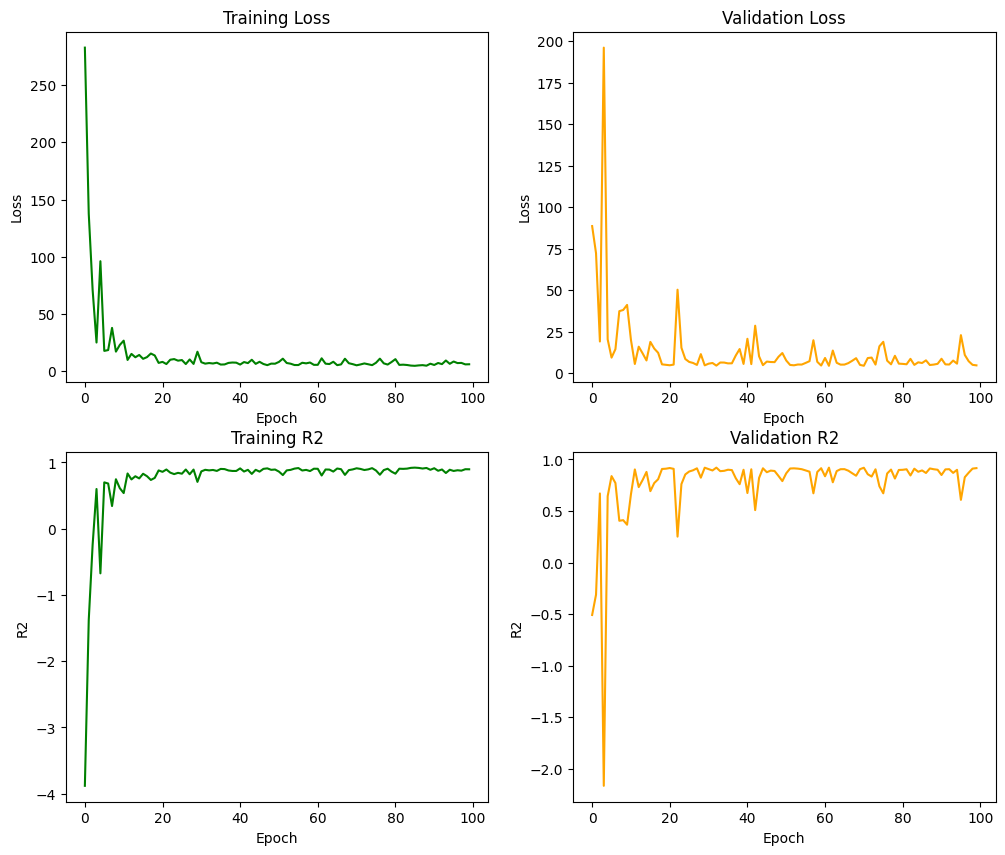

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training R2')

ax[1, 1].plot(val_r2, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation R2')

plt.show()

## **7. Evaluation**

In [114]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')

Evaluation on test set:
R2: 0.8417800068855286
